In [1]:
# !pip install opencv-python
# !pip install imgaug
# !pip install keras
# !pip install tensorflow
# !pip install pydot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os, random, pickle, json, itertools
import imgaug.augmenters as iaa
import imgaug.imgaug

from IPython.display import SVG
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from collections import Counter
from sklearn.utils import class_weight
from tqdm import tqdm # progress bar
from sklearn.preprocessing import LabelBinarizer
from keras.regularizers import l2

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model, model_to_dot
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Add, Input, Conv2D, Dropout, Activation, BatchNormalization, MaxPooling2D, ZeroPadding2D, AveragePooling2D, Flatten, Dense)
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, Callback, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import *

# Utility Functions

In [2]:
def show_final_history(history):

    plt.style.use("ggplot")
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    ax[0].set_title('Loss')
    ax[1].set_title('Accuracy')
    ax[0].plot(history.history['loss'],label='Train Loss')
    ax[0].plot(history.history['val_loss'],label='Validation Loss')
    ax[1].plot(history.history['binary_accuracy'],label='Train Accuracy')
    ax[1].plot(history.history['val_binary_accuracy'],label='Validation Accuracy')

    ax[0].legend(loc='upper right')
    ax[1].legend(loc='lower right')
    plt.show();
    pass

In [3]:
def plot_confusion_matrix(cm,classes,title='Confusion Matrix',cmap=plt.cm.Blues):
    cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes,rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j],fmt),
                horizontalalignment="center",
                color="white" if cm[i,j] > thresh else "black")
        pass

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass

# Uploading the images

In [ ]:
# from google.colab import files
# import zipfile
# import os

# # Step 1: upload the .zip file
# uploaded = files.upload()

# # assuming there is only one file
# zip_name = list(uploaded.keys())[0]

# # Step 2: Unzip the .zip file
# with zipfile.ZipFile(zip_name,"r") as zip_ref:
#     zip_ref.extractall()

# print("Folder uploaded successfully")

In [5]:
datasets = ['D:\Microsoft Hackthon\Data\Data Large\Data256New']

# class_names = ["Windmill","OilRig"]
class_names = ["Widmill_Filtered","OilRig_Filtered"]

class_name_labels = {class_name:i for i,class_name in enumerate(class_names)}

num_classes = len(class_names)
class_name_labels

{'Widmill_Filtered': 0, 'OilRig_Filtered': 1}

In [6]:
def load_data():
    images, labels = [], []

    for dataset in datasets:

        for folder in os.listdir(dataset):
            if folder in class_name_labels:
                label = class_name_labels[folder]

                for file in tqdm(os.listdir(os.path.join(dataset,folder))):
                    # Skip - Colab skip .ipy_checkpoints
                    if file.startswith('.'):
                        continue

                    img_path = os.path.join(dataset,folder,file)

                    # Ensure the path is a file (not a directory)
                    if os.path.isfile(img_path):
                        img = cv2.imread(img_path)
                        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                        img = cv2.resize(img, (48, 48))
                        images.append(img)
                        labels.append(label)

    images = np.array(images, dtype=np.float32)/255.0
    labels = np.array(labels, dtype=np.float32)

    return (images, labels)

In [7]:
(images, labels) = load_data()
images.shape, labels.shape

100%|██████████████████████████████████████████████████████████████████████████████| 5966/5966 [01:11<00:00, 82.91it/s]


((7460, 48, 48, 3), (7460,))

# Note that the folder contains 2 types of Image:
 - 1. Image with windmill
 - 2. Image with OilRigs

In [8]:
n_labels = labels.shape[0]

_, count = np.unique(labels, return_counts=True)

df = pd.DataFrame(data = count)
df['Class Label'] = class_names
df.columns = ['Count','Class-Label']
df.set_index('Class-Label',inplace=True)
df

,Count
Class-Label,
Widmill_Filtered,5965
OilRig_Filtered,1495


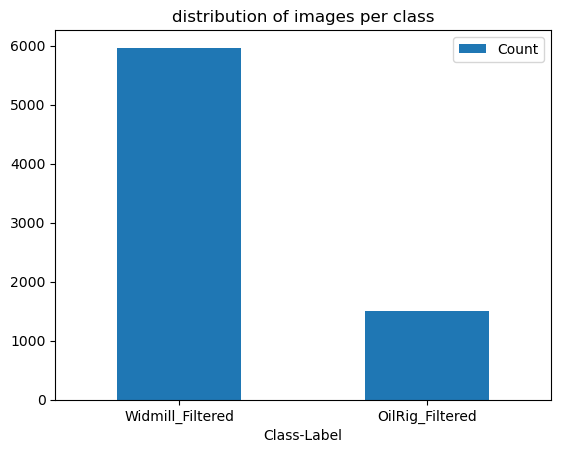

In [9]:
df.plot.bar(rot=0)
plt.title("distribution of images per class");

###### As it can be seen that the data is skewed towards the windmill class with 74.23% of images belonging to that very specific class.

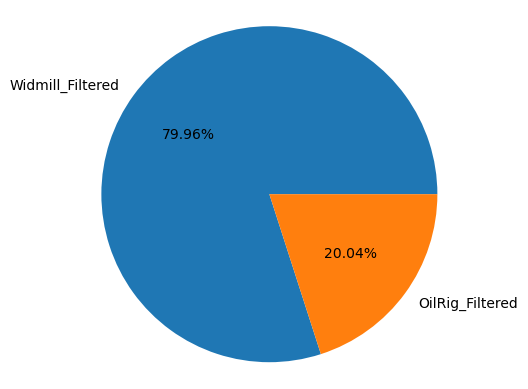

In [10]:
plt.pie(count,
       explode=(0,0),
       labels=class_names,
       autopct="%1.2f%%")
plt.axis('equal');

# Augument more image of oil rigs to address unequal sampling.

The current ratio of classes is 1:4 means every 1 oilrig image is for 4 windmill images. We need to produce addition 2 images for every Oil rigs. Because they are very similar. The augumentation will have very small parameter for altertation

In [11]:
AUGMENTATION = True

In [12]:
def augment_add(images, seq, labels):
    count_label_0 = np.sum(labels==0)
    count_label_1 = np.sum(labels==1)

    # calculate the multiplier to equalize the class ratio
    multiplier = count_label_0 // count_label_1

    augmented_images, augmented_labels = [],[]
    for idx,img in tqdm(enumerate(images)):

        if labels[idx] == 1:
            for _ in range(multiplier):
                image_aug = seq.augment_image(image=img)
                augmented_images.append(image_aug)
                augmented_labels.append(labels[idx])

    augmented_images = np.array(augmented_images, dtype=np.float32)
    augmented_labels = np.array(augmented_labels, dtype=np.float32)

    return (augmented_images, augmented_labels)

Parameter for augumentation

In [13]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5),  # horizontal flips
    iaa.Flipud(0.2),  # vertical flips
    iaa.Crop(percent=(0, 0.1)),  # random crops
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    # Strengthen or weaken the contrast in each image.
    iaa.LinearContrast((0.75, 1.5)),
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},  # scale images to 80-120% of their size, individually per axis
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},  # translate by -20 to +20 percent (per axis)
        rotate=(-25, 25),  # rotate by -25 to +25 degrees
        shear=(-8, 8),  # shear by -8 to +8 degrees
    )
], random_order=True)  # apply augmentations in random order

In [14]:
if AUGMENTATION:
    (aug_images, aug_labels) = augment_add(images, seq, labels)
    images = np.concatenate([images, aug_images])
    labels = np.concatenate([labels, aug_labels])

7460it [00:08, 913.67it/s]


In [15]:
images.shape, labels.shape

((11945, 48, 48, 3), (11945,))

# New data distrubtion after Data augumentation

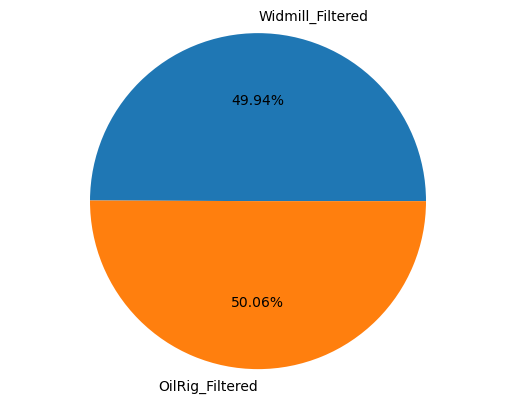

In [16]:
if AUGMENTATION:
    _, count = np.unique(labels, return_counts=True)

    plt.pie(count,
           explode=(0,0),
           labels=class_names,
           autopct="%1.2f%%")
    plt.axis('equal');

## close to 50/50. We are happy.

# Convert

In [17]:
labels = (labels > 0.5).astype(int)


# Train, Validation, Testing data set split

In [18]:
np.random.seed(42)
np.random.shuffle(images)

np.random.seed(42)
np.random.shuffle(labels)

# Classic split ratio : 70% - 20% - 10% split

In [19]:
total_count = len(images)
total_count

train = int(0.7*total_count)
val = int(0.2*total_count)
test = int(0.1*total_count)

train_images, train_labels = images[:train], labels[:train]
val_images, val_labels = images[train:(val+train)], labels[train:(val+train)]
test_images, test_labels = images[-test:], labels[-test:]

print(train_images.shape, val_images.shape, test_images.shape)

print(train_labels.shape, val_labels.shape, test_labels.shape)

(8361, 48, 48, 3) (2389, 48, 48, 3) (1194, 48, 48, 3)
(8361,) (2389,) (1194,)


In [20]:
if not AUGMENTATION:
    count_labels = train_labels.sum(axis=0)

    classTotals = train_labels.sum(axis=0)
    classWeight = {}

    for i in range(0,len(classTotals)):
        classWeight[i] = classTotals.max()/classTotals[i]
        pass
    print(classWeight)

## Overfitting:
Add a penalty for complexity to the loss function. Increase the regularization strength, reduce the model complexity, or get more data for training if possible.

In [21]:
def conv_block(X,k,filters,stage,block,s=2,dropout=0.5,regularizer=l2(0.01)):

    conv_base_name = 'conv_' + str(stage)+block+'_branch'
    bn_base_name = 'bn_'+str(stage)+block+"_branch"

    F1 = filters

    X = Conv2D(filters=F1, kernel_size=(k,k), strides=(s,s),
              padding='same',name=conv_base_name+'2a', kernel_regularizer=regularizer)(X)
    X = BatchNormalization(name=bn_base_name+'2a')(X)
    X = Activation('relu')(X)
    X = Dropout(dropout)(X)

    return X

In [22]:
def basic_model(input_shape,classes,dropout=0.5,regularizer=l2(0.01)):

    X_input = Input(input_shape)

    X = ZeroPadding2D((3,3))(X_input)

    X = Conv2D(8,(3,3),strides=(2,2),name='conv1',padding="same", kernel_regularizer=regularizer)(X)
    X = BatchNormalization(name='bn_conv1')(X)

    # stage 2
    X = conv_block(X,3,16,2,block='A',s=1,dropout=dropout,regularizer=regularizer)
    X = MaxPooling2D((2,2))(X)

    # Stage 3
    X = conv_block(X,5,16,3,block='A',s=2,dropout=dropout,regularizer=regularizer)
    X = MaxPooling2D((2,2))(X)

    # Stage 4
    X = conv_block(X,3,32,4,block='A',s=1,dropout=dropout,regularizer=regularizer)
    X = MaxPooling2D((2,2))(X)

    # Output Layer
    X = Flatten()(X)
    X = Dense(32, kernel_regularizer=regularizer)(X)
    X = Dropout(dropout)(X)

    X = Dense(64, kernel_regularizer=regularizer)(X)
    X = Activation("relu")(X)

    X = Dense(1,activation="sigmoid",name="fc"+str(classes))(X)

    model = Model(inputs=X_input,outputs=X,name='WindmillOil')

    return model

In [23]:
model = basic_model(input_shape=(48,48,3),classes=2)

# Model structure

In [24]:
plot_model(model,to_file='basic_model.png')
# SVG(model_to_dot(model).create(prog='dot',format='svg'))

model.summary()

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Model: "WindmillOil"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 zero_padding2d (ZeroPaddin  (None, 54, 54, 3)         0         
 g2D)                                                            
                                                                 
 conv1 (Conv2D)              (None, 27, 27, 8)         224       
                                                                 
 bn_conv1 (BatchNormalizati  (None, 27, 27, 8)         32        
 on)                                                             
                                                                 
 conv_2A_branch2a (Conv2D)   (None, 27

## Complie

come back check learning rate

In [25]:
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['binary_accuracy'])


In [26]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)

In [27]:
logs = TensorBoard('D:\Microsoft Hackthon\Code/my_logs')

# Training

1. Try 10 Epoch 32 batch size

- Try 100 eporch

In [28]:
epochs = 100
batch_size = 32
steps_per_epoch = len(train_images)// batch_size

print(steps_per_epoch)

261


In [29]:
print(f'Training images length: {len(train_images)}')
print(f'Validation images length: {len(val_images)}')
print(f'Steps per epoch: {len(train_images)//batch_size}')
print(f'Validation steps: {len(val_images)//batch_size}')

Training images length: 8361
Validation images length: 2389
Steps per epoch: 261
Validation steps: 74


In [30]:
history = model.fit(train_images,train_labels,
                   epochs=epochs,
                   verbose=1,
                   validation_data=(val_images,val_labels),
                   callbacks=[logs, early_stopping, lr_schedule]
                   )

Epoch 1/100
262/262 [==============================] - 8s 23ms/step - loss: 1.3007 - binary_accuracy: 0.8678 - val_loss: 1.5068 - val_binary_accuracy: 0.5119 - lr: 0.0010
Epoch 2/100
262/262 [==============================] - 5s 21ms/step - loss: 0.6869 - binary_accuracy: 0.9354 - val_loss: 0.9703 - val_binary_accuracy: 0.5902 - lr: 0.0010
Epoch 3/100
262/262 [==============================] - 6s 24ms/step - loss: 0.4189 - binary_accuracy: 0.9462 - val_loss: 0.8853 - val_binary_accuracy: 0.5643 - lr: 0.0010
Epoch 4/100
262/262 [==============================] - 7s 28ms/step - loss: 0.2917 - binary_accuracy: 0.9499 - val_loss: 0.4355 - val_binary_accuracy: 0.8882 - lr: 0.0010
Epoch 5/100
262/262 [==============================] - 7s 27ms/step - loss: 0.2378 - binary_accuracy: 0.9514 - val_loss: 0.3702 - val_binary_accuracy: 0.9573 - lr: 0.0010
Epoch 6/100
262/262 [==============================] - 7s 27ms/step - loss: 0.2034 - binary_accuracy: 0.9575 - val_loss: 0.4044 - val_binary_accu

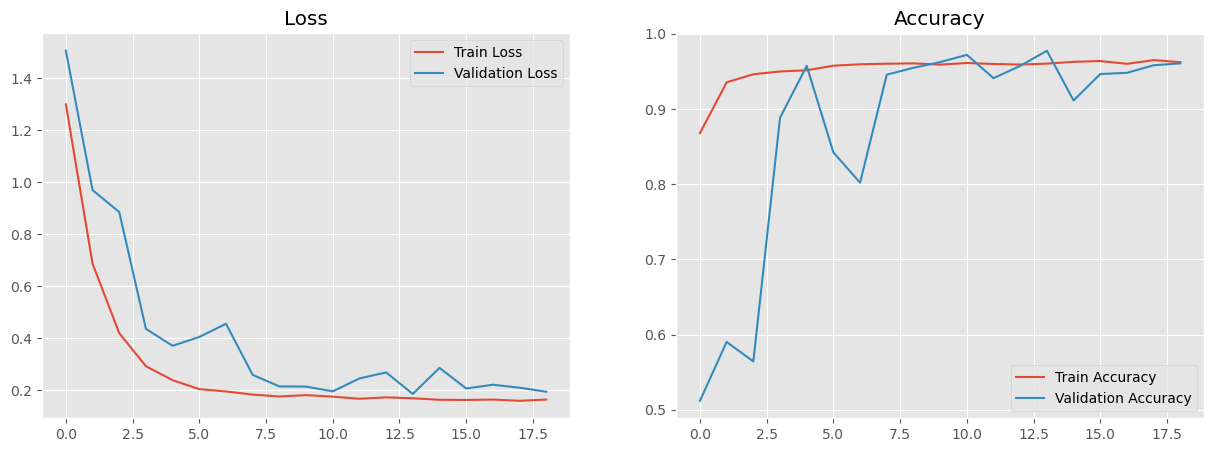

In [31]:
show_final_history(history)

In [32]:
val_pred = model.predict(val_images)
val_pred = np.squeeze(val_pred)
val_pred.shape


75/75 [==============================] - 1s 9ms/step


(2389,)

75/75 [==============================] - 1s 8ms/step


<Figure size 640x480 with 0 Axes>

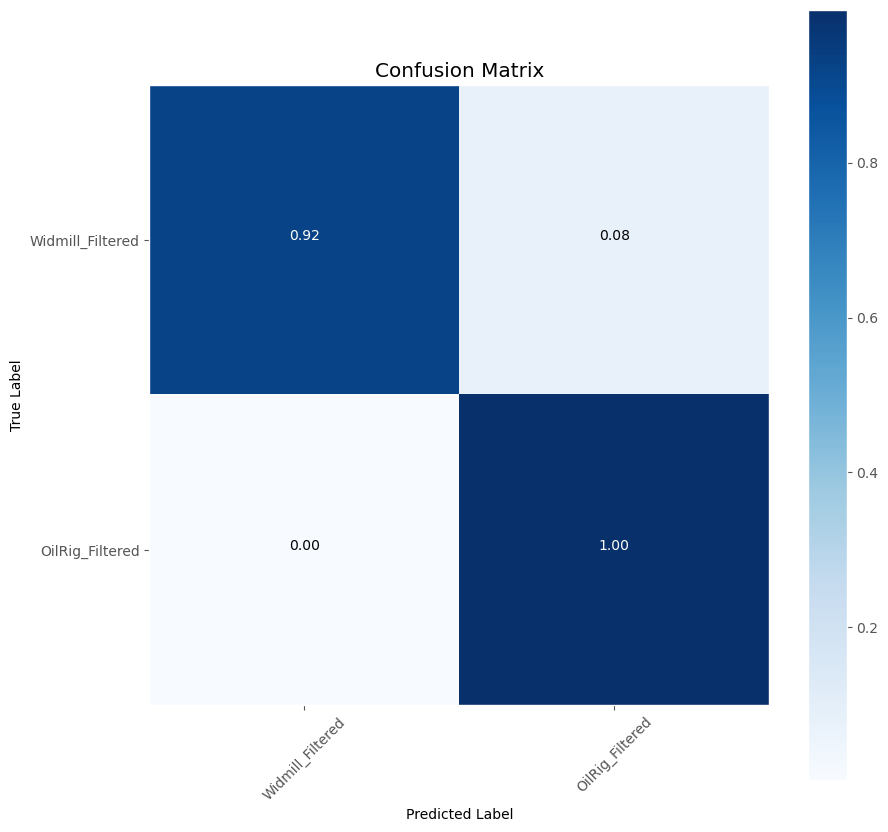

In [33]:
val_pred = model.predict(val_images)
val_pred = np.squeeze(val_pred)
val_pred = (val_pred > 0.5).astype(int)


val_actual = val_labels

cnf_mat = confusion_matrix(val_actual, val_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_mat,classes=class_names)
plt.grid(None)
plt.show();

In [36]:
test_pred2 = model.predict(test_images)
test_pred2 = np.squeeze(test_pred)
test_pred = (test_pred2 > 0.5).astype(int)

38/38 [==============================] - 0s 8ms/step


<Figure size 640x480 with 0 Axes>

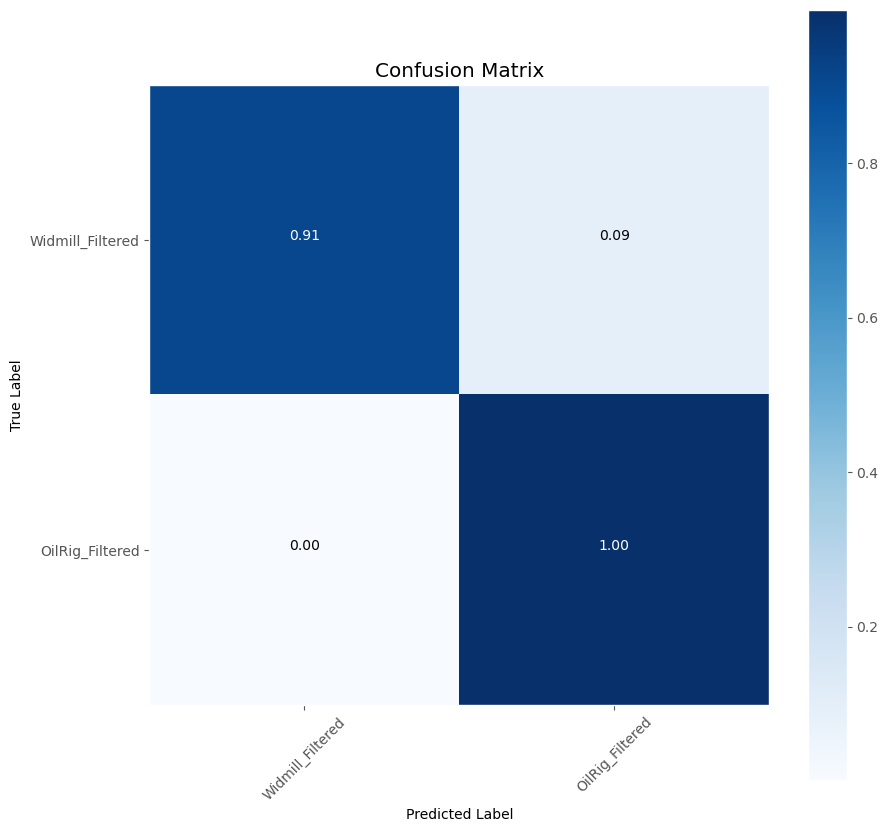

In [37]:
test_actual = test_labels
cnf_mat_test = confusion_matrix(test_actual, test_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_mat_test,classes=class_names)
plt.grid(None)
plt.show()

# Random Check

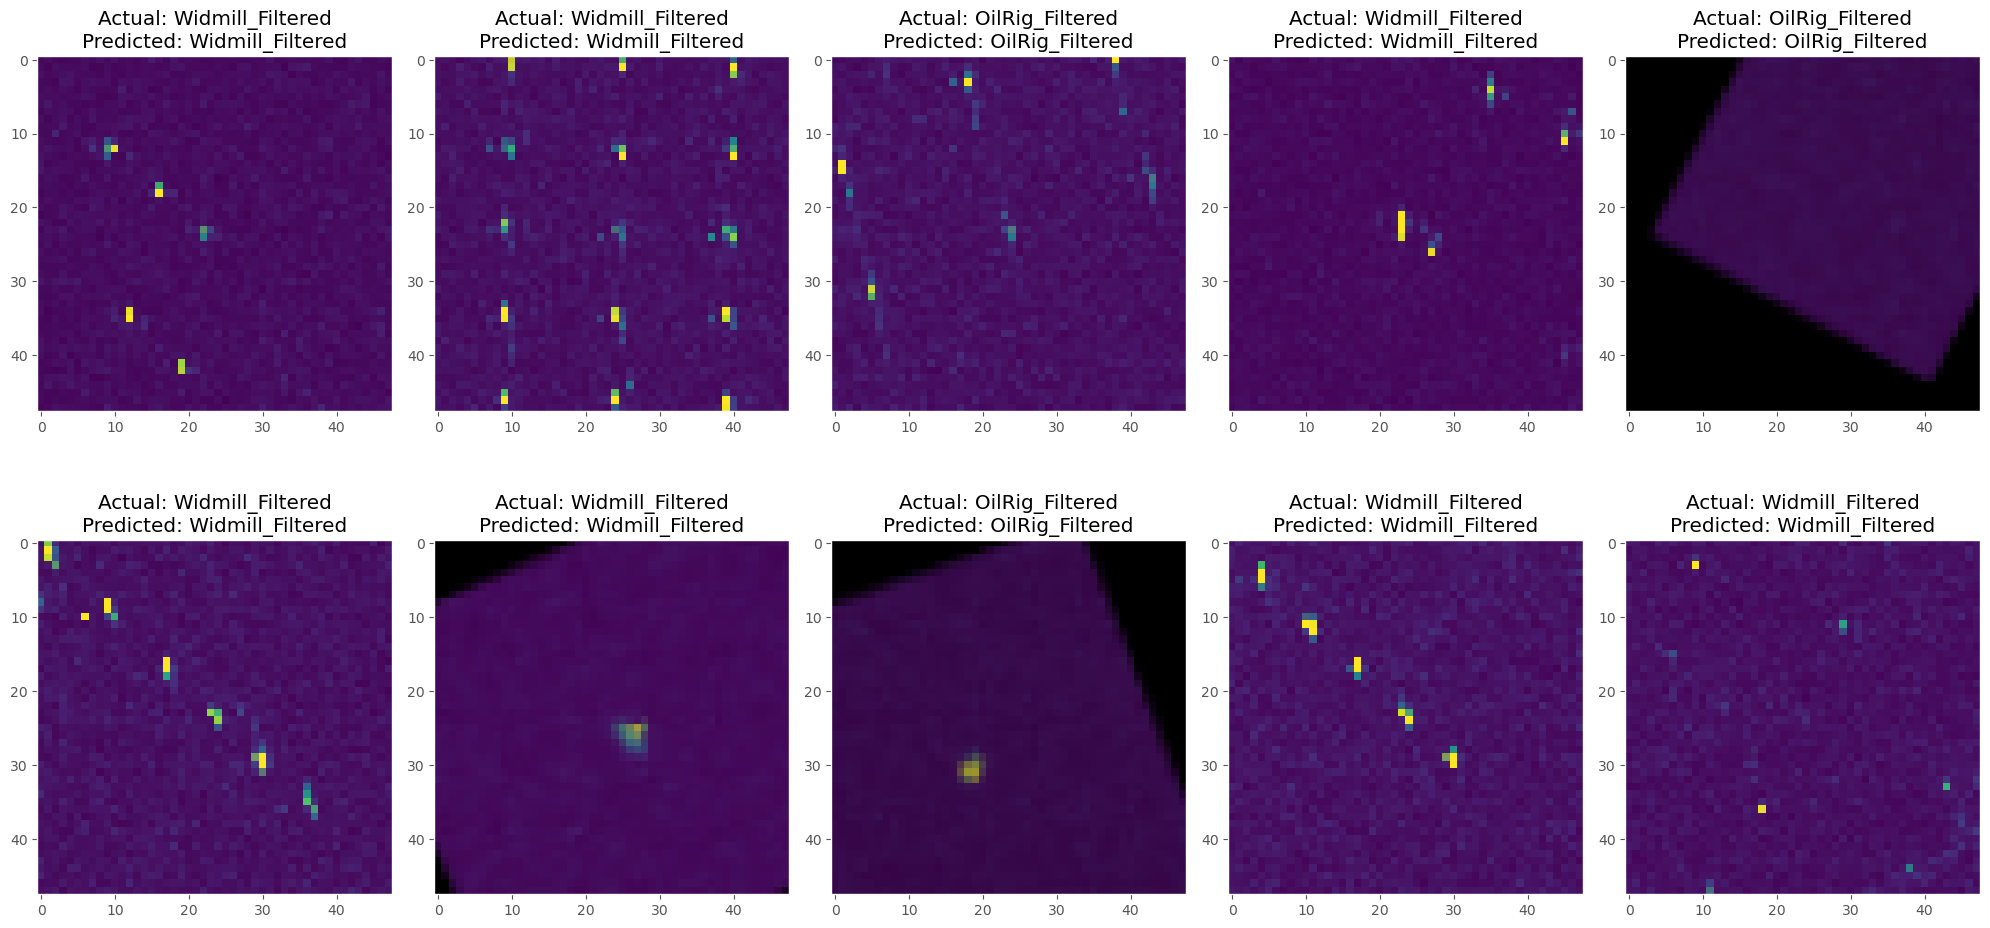

In [40]:
rnd_idx = random.sample(range(0, 400), 10)
class_labels = {i: class_name for (class_name, i) in class_name_labels.items()}

fig, ax = plt.subplots(2, 5, figsize=(20, 10))

for i, idx in enumerate(rnd_idx):
    row = i // 5
    col = i % 5

    ax[row, col].imshow(test_images[idx])
    ax[row, col].set_title("Actual: {}\nPredicted: {}".format(class_labels[val_actual[idx]], class_labels[val_pred[idx]]))
    ax[row, col].grid(None)

plt.tight_layout()
plt.show()

In [42]:
model.save("D:\Microsoft Hackthon\Model\WindLandOil_Model_Final_265.h5")